In [14]:

import os
import json
import yaml
import torch
import random
import detectron2

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import distutils.version

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import wandb
import tensorboard

from train import get_dataset_dicts, get_dataset_dicts_with_regions, random_visu, setup_cfg, MyTrainer, load_json_arr, find_best_model

import shutil

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [15]:
# Check tb to avoid error during training 
tensorboard.__version__

'2.12.0'

In [20]:
#Verify GPU information
print (torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.device(0)
       , torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


# Additional info when using CUDA
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
torch.cuda.empty_cache()
    
# Set CUDA configuration to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

# Limit GPU memory usage to 90%
torch.cuda.set_per_process_memory_fraction(0.9)

# Clear GPU memory
torch.cuda.empty_cache()


True 1 0 <torch.cuda.device object at 0x1553e4a7e160> NVIDIA A30 MIG 2g.12gb
Using device: cuda

NVIDIA A30 MIG 2g.12gb
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
### Split the json per type we want to run the model on, I did this because I wanted to train the model for each class seperately. 
### Not necessary if you want to do a multiclass training (recommend for future research)
### Note: you have to do this only once

# Specify the path to the directory containing the datasets
path = "../Satellite/"  # Update this to your actual dataset path

# Define the types we are interested in
types = ['raw', 'refinery', 'container', 'oil/gas', 'roro', 'warehouse']

# Mapping to replace problematic characters in type names for filenames
type_map = {
    'oil/gas': 'oil_gas'
}

for d in ["train", "test", "val"]:
    json_file_path = os.path.join(path, d, "nso_with_empty_annotations.json")
    
    with open(json_file_path, "r") as f:
        data = json.load(f)
    
    for t in types:
        # Use the type_map to get the correct file-safe type name
        file_safe_type = type_map.get(t, t)
        filtered_data = {}
        
        for k, v in data.items():
            filtered_regions = {rk: rv for rk, rv in v['regions'].items() if rv['region_attributes'].get('type') == t}
            if filtered_regions:
                filtered_data[k] = v.copy()
                filtered_data[k]['regions'] = filtered_regions
        
        output_file_path = os.path.join(path, d, f"via_region_data_{file_safe_type}_annotations.json")
        os.makedirs(os.path.dirname(output_file_path), exist_ok=True)  # Ensure the directory exists
        
        with open(output_file_path, "w") as out_file:
            json.dump(filtered_data, out_file, indent=4)
        
        print(f"Done creating {output_file_path} for type {t}")


In [7]:
### Set up

container_annotation = "via_region_data_container_annotations.json"
refinery_annotation = "via_region_data_refinery_annotations.json"
raw_annotation = "via_region_data_raw_annotations.json"
oil_gas_annotation = "via_region_data_oil_gas_annotations.json"
roro_annotation = "via_region_data_roro_annotations.json"
warehouse_annotation = "via_region_data_warehouse_annotations.json"

## Name annotations.json file in train and val ##
annotation_json = warehouse_annotation #Change for every class that you are training 
experiment_name = "lr001_BS4_warehouse_test__aug_3" #Change for every class that you are training 
conf_name = "NSOD2cfg_1000_169r_1000pix_noBT_" + experiment_name
conf_file = conf_name + ".yaml"

# Create a new output directory for output and metrics, if it doesn't exist
out_dir = "../Satellite/output/" + experiment_name
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    print ("The new out_dir directory is created!")

## Evaluation
# If test set is val:
val_coco_json = "val_coco_format.json"

In [8]:
### ARGS ###


## D2 Configuration Args ##
base_model_ = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

trains_ = ("train",)
tests_ = ("val",)
workers_ = 2
base_lr_ = 0.0001
eval_period_ = 100
warm_iter_ = 200
ims_per_batch_ = 2
max_iter_ = 10000
out_dir_ = out_dir
filter_empty_annot_ = False

## Patience for early stopping ##
num_patience = 10



In [9]:
### Indicate to D2 how to read dataset if not in coco format: ###

# D2 metadata: name of classes and colors of annotations
classes = ["Warehouse"] #Change for every class that you are training 
colors = [(249, 180, 45)]

# Register dataset and metadata
for d in ["train", "val"]:
    DatasetCatalog.register(d, lambda d=d:
                            get_dataset_dicts(os.path.join("../Satellite", d), annotation_json))
    # Key-value mapping to interpret what’s in the dataset: names of classes, colors of classes
    MetadataCatalog.get(d).thing_classes = classes
    MetadataCatalog.get(d).thing_colors = colors
     

In [10]:
def get_dataset_dicts(img_dir, annotation_json):
    """
    Function that tells detectron2 how to obtain a custom dataset by specifying it similarly to COCO’s annotations.

    Args:
        img_dir (str): Path to the directory containing the images and annotations .json file.
        annotation_json (str): Name of the JSON file with annotations.

    Returns:
        list: List of dictionaries containing the information of the dataset.
    """
    json_file = os.path.join(img_dir, annotation_json)
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    for idx, annots in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, annots["filename"])
        height, width = cv.imread(filename).shape[:2]
        
        # Info on the tile .png file
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        # Info on annotation
        annotations = annots["regions"]
        objs = []
        for _, anno in annotations.items():
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px),
                         np.min(py),
                         np.max(px),
                         np.max(py)
                        ],
                # XYXY_ABS: https://detectron2.readthedocs.io/en/latest/_modules/detectron2/structures/boxes.html
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": anno["category"]
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


../Satellite/train/259_Drammen_1000_2000.png


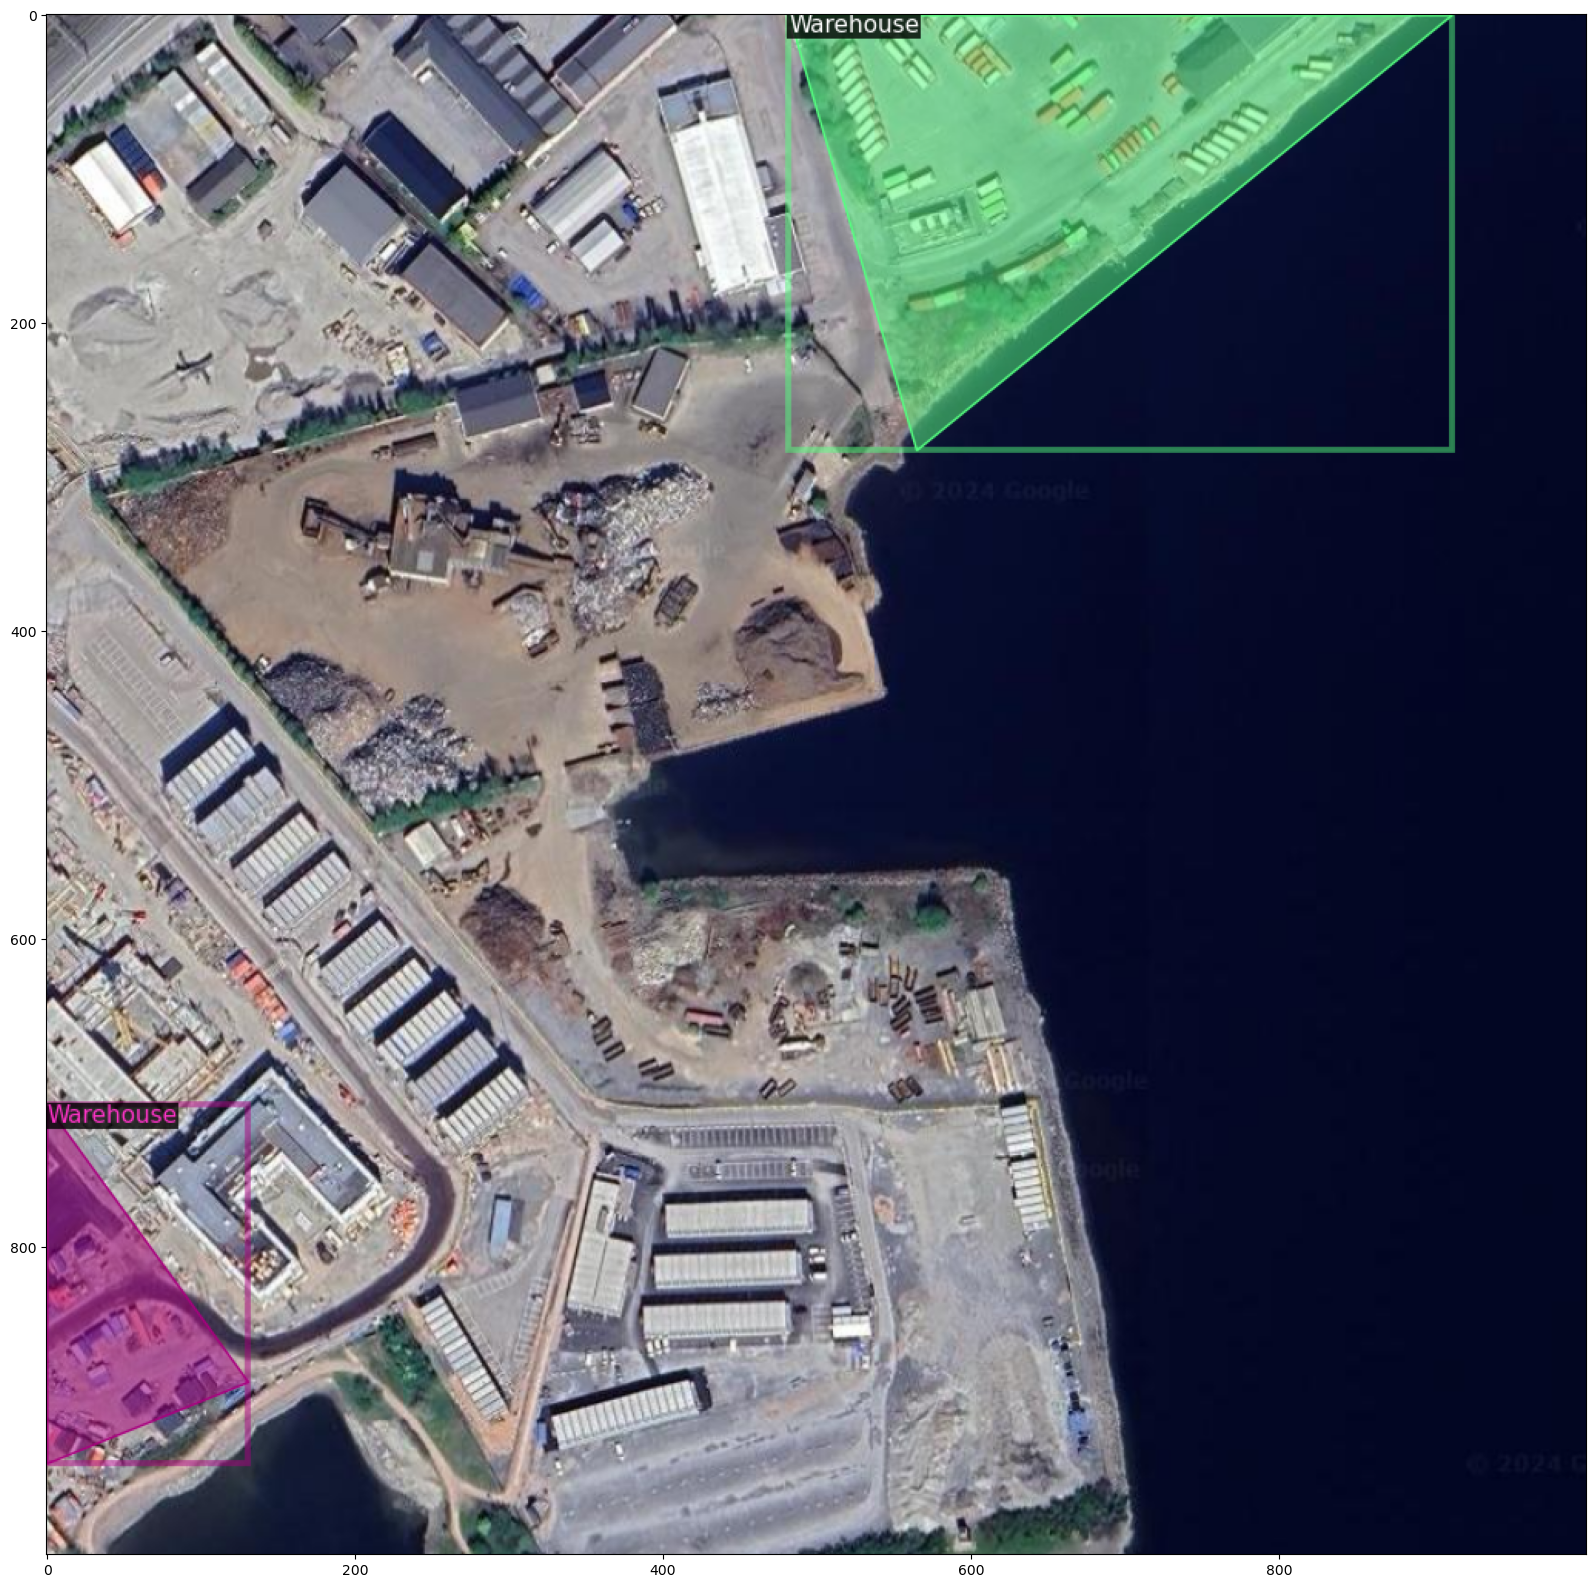

In [11]:
# Visualize annotations & images of training dataset
metadata = MetadataCatalog.get("train")
dataset_dicts = get_dataset_dicts("../Satellite/train", annotation_json)

# Visualize dataset
random_visu(dataset_dicts, metadata, 1)

In [12]:
### Make D2 configuration  ###

cfg = setup_cfg(base_model=base_model_, trains=trains_, tests=tests_, workers=workers_, base_lr=base_lr_, eval_period=eval_period_, warm_iter=warm_iter_,
                ims_per_batch=ims_per_batch_, max_iter=max_iter_, out_dir=out_dir_, filter_empty_annot=filter_empty_annot_)
# update_model arg can be used to load already trained model
#cfg.INPUT.MIN_SIZE_TRAIN = 1000

# Save your configurations
with open(os.path.join(out_dir, conf_file), "w") as file:
    yaml.dump(cfg, file)
print(cfg.dump())

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: false
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - val
  TRAIN:
  - train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1000
  MAX_SIZE_TRAIN: 1000
  MIN_SIZE_TEST: 0
  MIN_SIZE_TRAIN:
  - 1000
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: none
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_F

In [13]:
### Set up logging with Wandb ###

## If cfg is not defined, load it from yaml file: ##
#config = load_yaml(os.path.join(out_dir, conf_file))
#wandb.login()

# COMMENT OUT: AttributeError: module 'cgi' has no attribute 'escape': requirements tensorboard>=2.4.0 #167
#%load_ext tensorboard
#%tensorboard --logdir output

# Give the same name as output subfolder and confname - no need for wandb.login() at beginning if wand.init() is used
os.environ["WANDB_NOTEBOOK_NAME"] = "config_train_evaluate.ipynb"
wandb.init(
    project='P1',
    sync_tensorboard=True,
    save_code=True,
    config=cfg,
    name=experiment_name,
    notes=annotation_json,
    settings=wandb.Settings(
        start_method="thread",
        console="off"
    )
)


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find config_train_evaluate.ipynb.
2024-06-19 15:23:31.374870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 15:23:50.824405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
wandb: Currently logged in as: florinejonkers (florine_jonkers). Use `wandb login --relogin` to force relogin


In [ ]:
### Training with eval ###

def get_dataset_dicts(img_dir, annotation_json):
    """
    Function that tells detectron2 how to obtain a custom dataset by specifying it similarly to COCO’s annotations.

    Args:
        img_dir (str): Path to the directory containing the images and annotations .json file.
        annotation_json (str): Name of the JSON file with annotations.

    Returns:
        list: List of dictionaries containing the information of the dataset.
    """
    img_dir = "../Satellite/train"
    json_file = os.path.join(img_dir, "via_region_data_warehouse_annotations.json") #Change for every class that you are training 
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    for idx, annots in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, annots["filename"])
        height, width = cv.imread(filename).shape[:2]
        
        # Info on the tile .png file
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        # Info on annotation
        annotations = annots["regions"]
        objs = []
        for _, anno in annotations.items():
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px),
                         np.min(py),
                         np.max(px),
                         np.max(py)
                        ],
                # XYXY_ABS: https://detectron2.readthedocs.io/en/latest/_modules/detectron2/structures/boxes.html
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": anno["category"]
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

trainer = MyTrainer(cfg, patience=10)
trainer.resume_or_load(resume=False)
trainer.train()
print("Training finished.\n")

epoch is MAX_ITER * BATCH_SIZE / TOTAL_NUM_IMAGES

total_loss: This is a weighted sum of the following individual losses calculated during the iteration. By default, the weights are all one.

loss_cls: Classification loss in the ROI head. Measures the loss for box classification, i.e., how good the model is at labelling a predicted box with the correct class.

loss_box_reg: Localisation loss in the ROI head. Measures the loss for box localisation (predicted location vs true location).

loss_rpn_cls: Classification loss in the Region Proposal Network. Measures the "objectness" loss, i.e., how good the RPN is at labelling the anchor boxes as foreground or background.

loss_rpn_loc: Localisation loss in the Region Proposal Network. Measures the loss for localisation of the predicted regions in the RPN.

loss_mask: Mask loss in the Mask head. Measures how "correct" the predicted binary masks are.

For more details on the losses (1) and (2), take a look at the Fast R-CNN paper and the code.

For more details on the losses (3) and (4), take a look at the Faster R-CNN paper and the code.

For more details on the loss (5), take a look at the Mask R-CNN paper and the code.

In [ ]:
### Make figure directory ###

# Create a new directory to place figures
fig_dir = "../fig"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print ("The figure directory is created!")

# Directory for figures of each configuration
experiment_fig_dir = os.path.join(fig_dir, conf_name) 
if not os.path.exists(experiment_fig_dir):
    os.makedirs(experiment_fig_dir)
    print ("The figure plot directory is created!")

In [ ]:
### Plot training and validation loss, accuracy, AP50 - train/val ###

# Load json with metrics
experiment_folder = out_dir
experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')


# Loss plot
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x], label='Total Validation Loss', color='red')
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x], label='Total Training Loss')
plt.legend(loc='upper right')
plt.title('Comparison of the training and validation loss of Mask R-CNN')
plt.ylabel('Total Loss')
plt.xlabel('Number of Iterations')
plt.savefig(experiment_fig_dir + '/loss.png')
plt.show()

# Accuracy
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'mask_rcnn/accuracy' in x], 
    [x['mask_rcnn/accuracy'] for x in experiment_metrics if 'mask_rcnn/accuracy' in x], label='mask_rcnn/accuracy', color='red')
plt.legend(loc='upper right')
plt.title('mask_rcnn/accuracy')
plt.ylabel('accuracy')
plt.xlabel('Number of Iterations')
plt.savefig(experiment_fig_dir +'/acuracy.png')
plt.show()

# AP50 - val ###
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_ap' in x], 
    [x['validation_ap'] for x in experiment_metrics if 'validation_ap' in x], label='Site Validation AP50', color='red')
plt.legend(loc='upper right')
plt.title('Validation set - AP50')
plt.ylabel('AP50')
plt.xlabel('Number of Iterations')
plt.savefig(experiment_fig_dir+'/AP50_val.png')
plt.show()

# AP50 - train
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'segm/AP50' in x], 
    [x['segm/AP50'] for x in experiment_metrics if 'segm/AP50' in x], label='Segmentation AP50', color='red')
plt.legend(loc='upper right')
plt.title('Training set - Segmentation AP50')
plt.ylabel('AP50')
plt.xlabel('Number of Iterations')
plt.savefig(experiment_fig_dir +'/AP50_train.png')
plt.show()


In [ ]:
### IF the config were NOT previously registered, run those cells ###

cfg = get_cfg()
cfg.OUTPUT_DIR = out_dir
config_path = os.path.join(out_dir, conf_file)
#cfg.INPUT.MIN_SIZE_TRAIN = 1000
#cfg.RESIZE= False

In [ ]:
# ### If val not registered previsously, register it ###

# #Metedata
# # Define classes based on the unique types in the dataset
# classes = ["Container"]
# #lasses = ["Refinery"]
# #classes = ["Raw material"]
# #classes = ["Oil and Gas storage"]
# #classes = ["Roll on Roll off"]
# # classes = ["Warehouse"]

# # Assign a unique color to each class (you may want to choose these colors manually if specific colors are required)
# colors = [(249, 180, 45)]
# # Register dataset and metadata
# for d in [ "val"]:
#     DatasetCatalog.register(d, lambda d=d:
#                             get_dataset_dicts(os.path.join("../Satellite", d), annotation_json))
#     # Key-value mapping to interpret what’s in the dataset: names of classes, colors of classes
#     MetadataCatalog.get(d).thing_classes = classes
#     MetadataCatalog.get(d).thing_colors = colors 

In [ ]:
# A) get_dataset_dicts ALL images of validation
dataset_dicts = get_dataset_dicts("../Satellite/val", annotation_json)
metadata = MetadataCatalog.get("val")

In [ ]:
# B: get_dataset_dicts only for images with validation: If there are a lot of empty annotations
def get_dataset_dicts(img_dir, annotation_json):
    """
    Function that tells detectron2 how to obtain a custom dataset by specifying it similarly to COCO’s annotations.

    Args:
        img_dir (str): Path to the directory containing the images and annotations .json file.
        annotation_json (str): Name of the JSON file with annotations.

    Returns:
        list: List of dictionaries containing the information of the dataset.
    """
    json_file = os.path.join(img_dir, "via_region_data_warehouse_annotations.json") #Change for every class that you are training 
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    for idx, annots in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, annots["filename"])
        height, width = cv.imread(filename).shape[:2]
        
        # Info on the tile .png file
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        # Info on annotation
        annotations = annots["regions"]
        objs = []
        for _, anno in annotations.items():
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px),
                         np.min(py),
                         np.max(px),
                         np.max(py)
                        ],
                # XYXY_ABS: https://detectron2.readthedocs.io/en/latest/_modules/detectron2/structures/boxes.html
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": anno["category"]
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


dataset_dicts = get_dataset_dicts_with_regions("../Satellite/val", annotation_json)
metadata = MetadataCatalog.get("val")

In [ ]:
### Find the best model in the output directory ###
best_model_path = find_best_model(out_dir, ".pth")

if best_model_path:
    best_model = best_model_path.split('/')[-1]
    print(f"Highest numbered file with extension .pth: is {best_model} at {best_model_path}")
else:
    print(f"No file with extension .pth found in the directory.")


In [ ]:
### Set config from training and select param for eval ###

out_dir = '../Satellite/output/lr001_BS4_warehouse_test__aug_3' #Change for every class that you are training 
conf_file = 'NSOD2cfg_1000_169r_1000pix_noBT_lr001_BS4_warehouse_test__aug_3.yaml' #Change for every class that you are training 
best_model = 'model_32.pth'  # Replace with your actual model filename

cfg = get_cfg()

# Set the modified parameters for inference
cfg.INPUT.MIN_SIZE_TRAIN = (1000,)
cfg.RESIZE = False

# Merge the configuration file
cfg.merge_from_file(os.path.join(out_dir, conf_file))

# Set the path to the trained model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, best_model)

# Set a custom testing threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01

# Specify the dataset to be used for testing
cfg.DATASETS.TEST = ("val", )

# Initialize the predictor
predictor = DefaultPredictor(cfg)

#Try me: https://github.com/facebookresearch/detectron2/issues/1059
#trainer = MyTrainer(cfg)
#trainer.resume_or_load(resume=True)

In [ ]:
### TEST Visualise inference ###
def get_dataset_dicts(img_dir, annotation_json):
    """
    Function that tells detectron2 how to obtain a custom dataset by specifying it similarly to COCO’s annotations.

    Args:
        img_dir (str): Path to the directory containing the images and annotations .json file.
        annotation_json (str): Name of the JSON file with annotations.

    Returns:
        list: List of dictionaries containing the information of the dataset.
    """
    json_file = os.path.join(img_dir, annotation_json)
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    for idx, annots in enumerate(imgs_anns):
        record = {}
        
        # Correct the file path
        if "train" in annots["file_name"]:
            corrected_filename = os.path.join("../Satellite/train", os.path.basename(annots["file_name"]))
        elif "val" in annots["file_name"]:
            corrected_filename = os.path.join("../Satellite/val", os.path.basename(annots["file_name"]))
        else:
            print(f"Unrecognized file path pattern: {annots['file_name']}")
            continue
        
        height, width = annots["height"], annots["width"]
        
        # Info on the tile .png file
        record["file_name"] = corrected_filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        # Info on annotation
        objs = []
        for anno in annots["annotations"]:
            poly = [(x + 0.5, y + 0.5) for x, y in zip(anno["segmentation"][0][::2], anno["segmentation"][0][1::2])]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": anno["bbox"],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": anno["category_id"]
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from visualisation_prediction import random_visu_prediction

#random_visu_prediction(dataset_dicts, metadata, predictor, experiment_fig_dir, 20)
predictor = DefaultPredictor(cfg)
random_visu_prediction(dataset_dicts, metadata, predictor, "output_directory", 20, threshold=0.6)

In [ ]:
### Copy "val_coco_format.json" from eval to out_dir ###

#GOAL: TO AVOID ISSUE FINDING val_coco_format.json WHILE EVALUATING

# Specify the paths to the source file and the destination folder
source_file = os.path.join(out_dir,"eval",val_coco_json)
destination_folder = os.path.join(out_dir)

# Construct the destination path by joining the destination folder and the source file's base name
destination_path = os.path.join(destination_folder, os.path.basename(source_file))

# Copy the file to the destination folder
shutil.copy(source_file, destination_path)

print(f"File copied to: {destination_path}")

In [ ]:
### Evaluate performance metrics with COCO API ###
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader



# Initialize the COCOEvaluator
evaluator = COCOEvaluator("val", output_dir=out_dir)
# Load the validation dataset
val_loader = build_detection_test_loader(cfg, "val")
# Perform inference and evaluation
results_inference = inference_on_dataset(predictor.model, val_loader, evaluator)
print (results_inference)

results_file_path = os.path.join(out_dir, "results.json")

# Save the results to a JSON file
with open(results_file_path, "w") as results_file:
    json.dump(results_inference, results_file)